In [2]:
import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mylib

$$\frac{d}{dx}\left(\nu\frac{du}{dx}\right)+\alpha\,u=f\qquad x\in\,(0,L)$$

cond(A) = 155.7400470031581
det(A) = -1.3981468690335147e+25
monolithic error = 4.547525550271139e-14
{'type': 'dirichlet', 'value': 2.0}
{'type': 'dirichlet', 'value': 2.0000000000000004}


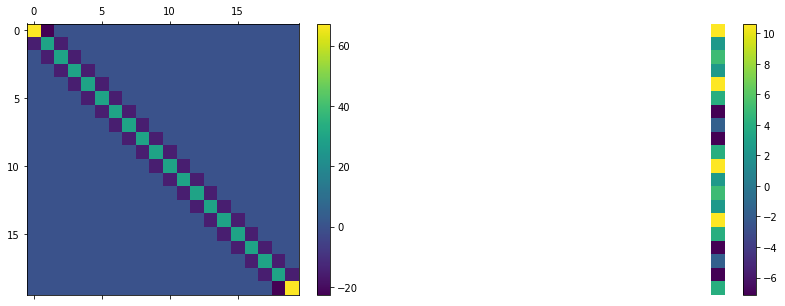

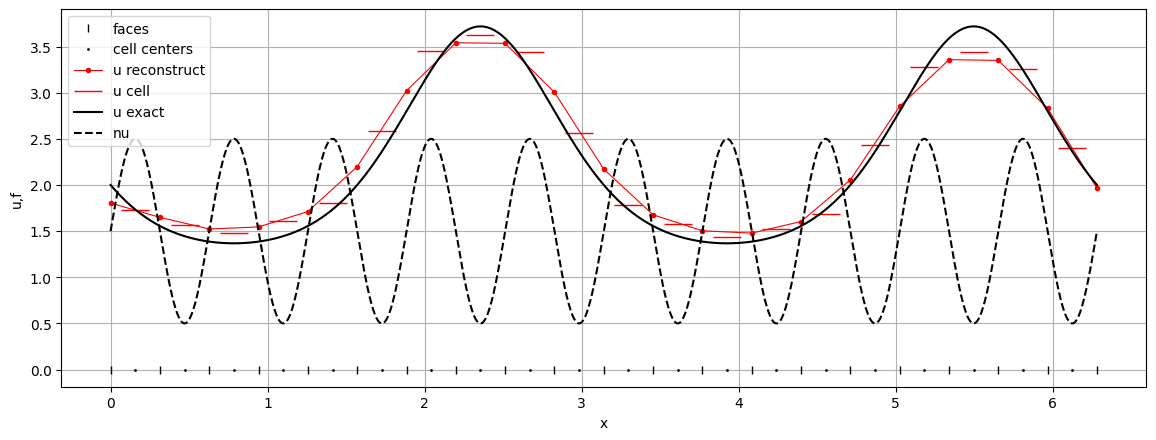

In [4]:
kwargs = {
    'a': 1.0,
    'b': 2.0,
    'c': 1.5,
    'd': 1.0,
    'freq': 10.0
}

L = 2.0*np.pi
N = 20
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)

alpha = 1.0

def sol(x, kwargs):
    a = kwargs.get('a')
    b = kwargs.get('b')
    return a + np.exp(-np.sin(b*x))

def nu(x, kwargs):
    c = kwargs.get('c')
    d = kwargs.get('d')
    freq = kwargs.get('freq')
    return c + d*np.sin(freq*x)

def lapl(x, kwargs):
    b = kwargs.get('b')
    c = kwargs.get('c')
    d = kwargs.get('d')
    freq = kwargs.get('freq')
    return (d*freq*np.cos(freq*x))*(-b*np.cos(b*x)*np.exp(-np.sin(b*x))) + (c+d*np.sin(freq*x))*np.square(b)*np.exp(-np.sin(b*x))*(np.sin(b*x)+np.square(np.cos(b*x)))
   
def f(x, kwargs):
    return alpha*sol(x, kwargs) + lapl(x, kwargs)
    
leftBC = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol(0.0, kwargs)}

rightBC = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol(L, kwargs)}

A1, fBC = mylib.laplacian(nu, leftBC, rightBC, N, dx, L, kwargs)
A2 = alpha*sparse.eye(N)
ff = f(xc, kwargs)
fTOT = fBC + ff

A = A1+A2
A = A.toarray()

A = -np.power(dx,0.0)*A
fTOT = -np.power(dx,0.0)*fTOT

#u = sparse.linalg.spsolve(A, fTOT)
#u = u[0]
u = linalg.solve(A, fTOT)

print("cond(A) =", np.linalg.cond(A))
print("det(A) =", np.linalg.det(A))
print(f"monolithic error = {np.linalg.norm(fTOT-np.dot(A,u))}")
print(leftBC)
print(rightBC)

fig1, axs = plt.subplots(1, 2, figsize=(14,5))
axsA = axs[0].matshow(A)
axsf = axs[1].matshow(ff.reshape((N,1)))
fig1.colorbar(axsA, ax=axs[0])
fig1.colorbar(axsf, ax=axs[1])
axs[1].axis('off')
#plt.savefig('matrix.pdf')

fig, ax = plt.subplots(figsize=(14,5), dpi=100)
markersize = 20
linewidth = 0.8
color = 'k'
ax.set_xlabel('x')
ax.set_ylabel('u,f')

ax.plot(x, 0*x, '|', color='k', label='faces', markersize=6.0)
ax.plot(xc, 0*xc, '.', color='k', label='cell centers', markersize=2.0)

ax.plot(x, mylib.reconstruct(u), '.-r' , label='u reconstruct', linewidth=linewidth)
ax.plot(xc, u, '_r', label='u cell', markersize=markersize)
ax.plot(xfine, sol(xfine, kwargs), '-k', label='u exact')

#ax.plot(x, mylib.reconstruct(fTOT), '-g' , label='furec', linewidth=linewidth)
#ax.plot(xc, ff, '_g', label='ff', markersize=markersize)
#ax.plot(xfine, f(xfine, kwargs), '--k', label='f exact')

ax.plot(xfine, nu(xfine, kwargs), '--k', label='nu')
ax.plot()
#ax.set_ylim(bottom=0.0)
#ax.set_xlim([-0.001,0.1])
ax.legend()
ax.grid()